In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [3]:

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nSample data:")
print(train_df.head())
print("\n")
print(train_df.columns.tolist())



Train shape: (19237, 18)
Test shape: (8245, 18)

Sample data:
         ID  Price  Levy Manufacturer    Model  Prod. year   Category  \
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep   
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep   
2  45774419   8467     -        HONDA      FIT        2006  Hatchback   
3  45769185   3607   862         FORD   Escape        2011       Jeep   
4  45809263  11726   446        HONDA      FIT        2014  Hatchback   

  Leather interior Fuel type Engine volume    Mileage  Cylinders  \
0              Yes    Hybrid           3.5  186005 km        6.0   
1               No    Petrol             3  192000 km        6.0   
2               No    Petrol           1.3  200000 km        4.0   
3              Yes    Hybrid           2.5  168966 km        4.0   
4              Yes    Petrol           1.3   91901 km        4.0   

  Gear box type Drive wheels   Doors             Wheel   Color  Airbags  
0     Automatic 

In [4]:
# Check missing values
print("\nMissing values:\n", train_df.isnull().sum())

print("\nDataset summary:\n", train_df.describe())

columns_to_keep = ['Engine_Size', 'Horsepower', 'Mileage', 'Price']
df = train_df.dropna(subset=['Price', 'Engine volume', 'Mileage'])

print("\nFinal columns used for training:\n", df.columns)




Missing values:
 ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

Dataset summary:
                  ID         Price    Prod. year     Cylinders       Airbags
count  1.923700e+04  1.923700e+04  19237.000000  19237.000000  19237.000000
mean   4.557654e+07  1.855593e+04   2010.912824      4.582991      6.582627
std    9.365914e+05  1.905813e+05      5.668673      1.199933      4.320168
min    2.074688e+07  1.000000e+00   1939.000000      1.000000      0.000000
25%    4.569837e+07  5.331000e+03   2009.000000      4.000000      4.000000
50%    4.577231e+07  1.317200e+04   2012.000000      4.000000      6.000000
75%    4.580204e+07  2

In [5]:
df['Mileage'] = df['Mileage'].astype(str).str.replace(' km', '').str.replace(',', '').astype(float)


df['Engine volume'] = df['Engine volume'].astype(str).str.replace(' Turbo', '').astype(float)


X = df[['Engine volume', 'Mileage']]
y = df['Price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Intercept (Fixed Cost): {model.intercept_:.2f}")
print(f"Coefficients: {model.coef_}")


Model Performance:
Mean Squared Error (MSE): 310289136.80
R² Score: 0.0042
Intercept (Fixed Cost): 15100.18
Coefficients: [ 1.67138953e+03 -6.45469470e-06]


In [9]:
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("\nFeature Contribution:")
print(feature_importance)

# Predict price for given values
engine_size = 2.0  
mileage = 15_000   
predicted_price = model.predict([[engine_size, mileage]])

print(f"\nPredicted Price for Engine: ${predicted_price[0]:.2f}")



Feature Contribution:
         Feature  Coefficient
0  Engine volume  1671.389530
1        Mileage    -0.000006

Predicted Price for Engine: $18442.86


e:\waste-classifier\car price\myvenv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


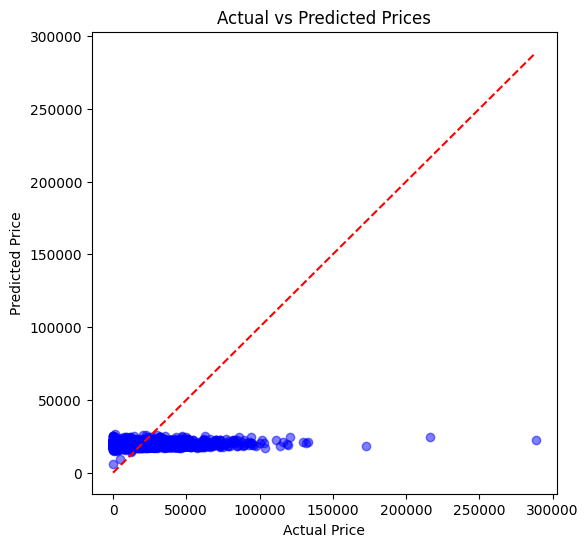

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line y=x
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()


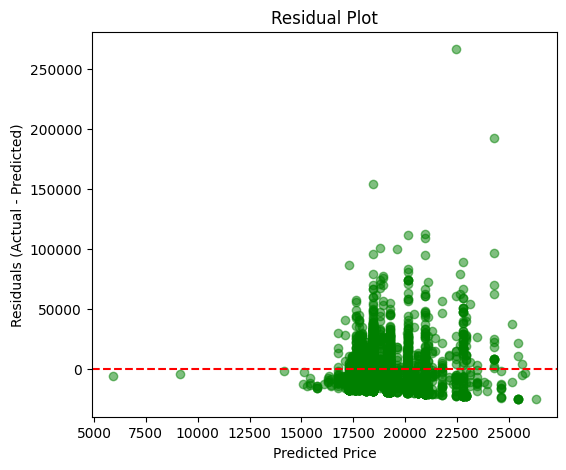

In [8]:
# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.5, color='green')
plt.axhline(y=0, color='r', linestyle='--')  # horizontal line at 0
plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()
